## __Plato Notebook 2: Optimisation with sediment lubrication, cratonic keels and slab suction__

Thomas Schouten, Whitney Behr, Edward Clennett, Thorsten Becker


#### __0. Prepare Python__

First, we load the required packages.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from plato.optimisation import Optimisation
from plato.plate_torques import PlateTorques
from plato.plot import PlotReconstruction

#### __1. Set up the PlateTorques object__

The below cell loads a `PlateTorques` object for the Müller et al. (2016) reconstruction by providing the ages of interest and the model string identifier "Muller2016", which automatically downloads the relevant files from the GPlately DataServer.

To accelerate the initialisation, the seafloor age and continental grids are loaded from the sample data folder. The seafloor age grids were obtained from the GPlately DataServer; the continental grids were obtained by reconstructing the present-day elevation as well as the depths of the Moho and lithosphere-asthenosphere (LAB) boundary from Lithoref (Afonso et al., 2019) using the `reconstruct` method of the GPlately `Raster` object.

In [2]:
# Set parameters
# Plate reconstruction
reconstruction_name = "Muller2016" 

# Reconstruction ages of interest
ages = [0]

# Load excel file with settings
settings_file = os.path.join(os.getcwd(), "settings.xlsx")

# Set directory with sample data
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "sample_data", "M2016"))

# Set directory to save the results
results_dir = "02-Results"

# Load seafloor age and continental grids
seafloor_age_grids = {}; continental_grids = {}
for age in ages:
    seafloor_age_grids[age] = xr.open_dataset(os.path.join(data_dir, "seafloor_age_grids", f"M2016_SeafloorAgeGrid_{age}Ma.nc"))
    continental_grids[age] = xr.open_dataset(os.path.join(data_dir, "continental_grids", f"M2016_ContinentalGrid_{age}Ma.nc"))

# Set up PlateTorques object
M2016 = PlateTorques(
    reconstruction_name = reconstruction_name, 
    ages = ages, 
    cases_file = settings_file,
    cases_sheet = "Notebook 2 - Optimisation",
    seafloor_age_grids = seafloor_age_grids,
    continental_grids = continental_grids,
    files_dir = results_dir,
)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


Calculating RMS velocities: 100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


#### __2. Sampling and LAB depth calculation__

The below cell calls the `sample_all` method of the `PlateTorques` object to sample seafloor ages at subduction zones and grid points and the `calculate_LAB_depths` to sample the LAB depth below continents and calculate it from the seafloor age below oceans.

In [3]:
M2016.sample_all()
M2016.calculate_lab_depths()

Calculating mean LAB depths: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


#### __3. Adding trench fill sediments__

The below cells add trench fill sediments to 

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of points on Earth.

    :param lat1:    Latitude of the first point in degrees.
    :type lat1:     float
    :param lon1:    Longitude of the first point in degrees.
    :type lon1:     float
    :param lat2:    Latitude of the second point in degrees.
    :type lat2:     float
    :param lon2:    Longitude of the second point in degrees.
    :type lon2:     float

    :return:        The Haversine distance between the two points.
    :rtype:         float
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return c

In [5]:
# Load Heuret et al. (2012) data
trench_sediment_thickness = pd.read_excel("/Users/thomas/Documents/_Plato/Sediment_lubrication_#2/Heuret2012_data.xlsx")

# Add Heuret et al. (2012) data (which is in km!!) to the sediment thickness column in slabs
for age in M2016.ages:
    for case in M2016.cases:
        if "seds" not in case:
            continue
        
        for i, _ in enumerate(M2016.slabs.data[age][case].lat):
            distance_to_segments = haversine(
                M2016.slabs.data[age][case].loc[i, "lat"],
                M2016.slabs.data[age][case].loc[i, "lon"],
                trench_sediment_thickness.Latitude,
                trench_sediment_thickness.Longitude
            )
            M2016.slabs.data[age][case].loc[i, "sediment_thickness"] = trench_sediment_thickness["Sediment thickness"][distance_to_segments.idxmin()] * 1e3

#### __4. Torque calculation__

The below cells uses the `calculate_all_torques` method of the `PlateTorques` object to compute the full torque balance for all cases with reconstructed motions.

In [6]:
M2016.calculate_all_torques(cases = "reconstructed")

Calculating slab pull torque on plates:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 'reconstructed'

#### __5. Optimisation__

The below cells initialise an `Optimisation` object, that contains methods to optimise the free parameters in the plate torque balance, using the `PlateTorques` object.

Then

In [9]:
optimise_M2016 = Optimisation(M2016)

 
Optimising ref
(250, 250, 250)


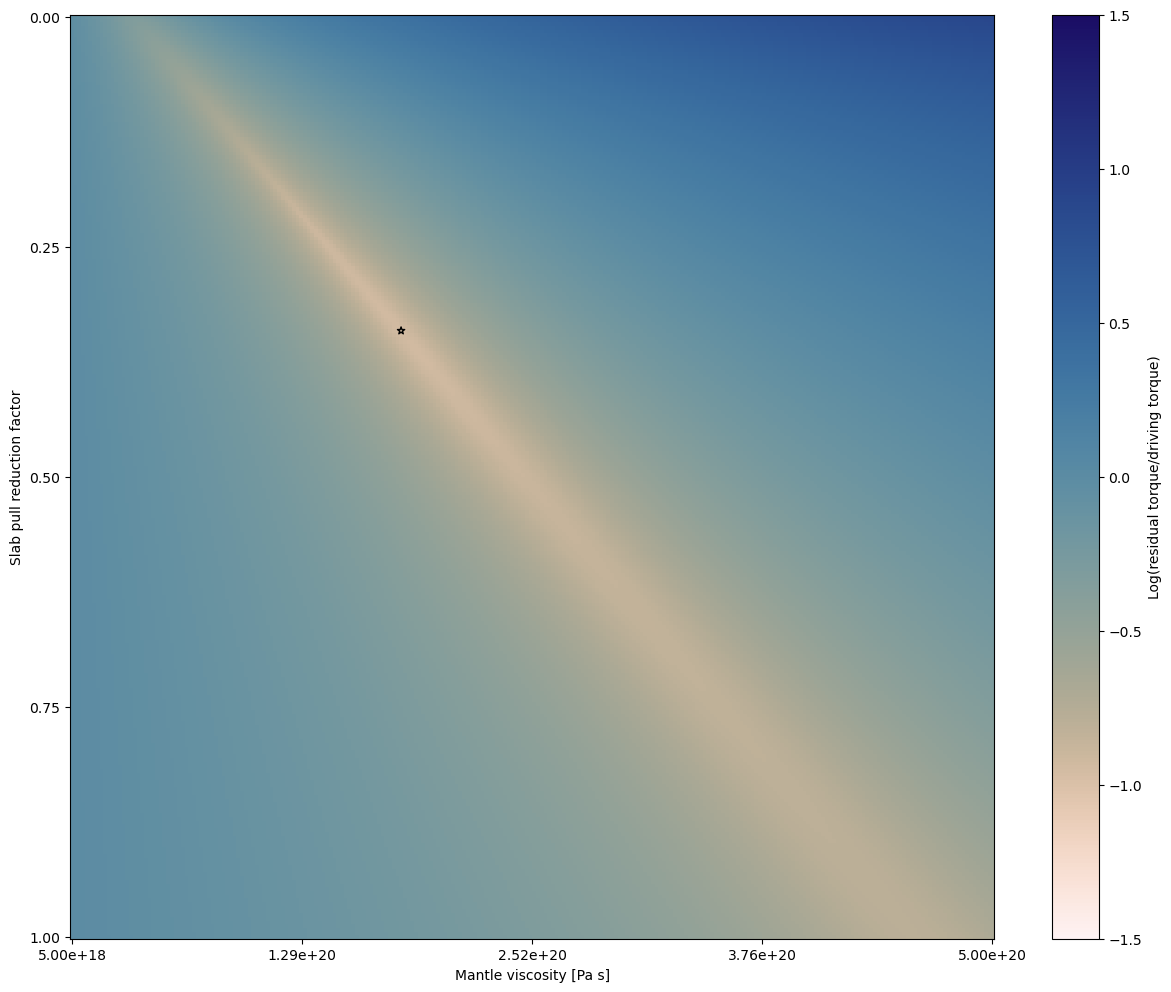

Optimal coefficients for  N America, S America, Pacific, Nazca  plate(s), (PlateIDs:  101.0, 201.0, 901.0, 911.0 )
Minimum residual torque: 11.34% of driving torque
Optimum viscosity [Pa s]: 1.82e+20
Optimum Drag Coefficient [Pa s/m]: 9.10e+14
Optimum Slab Pull constant: 34.14%
Optimum Slab Suction constant: 0.00%
 
Optimising seds
(250, 250, 250)


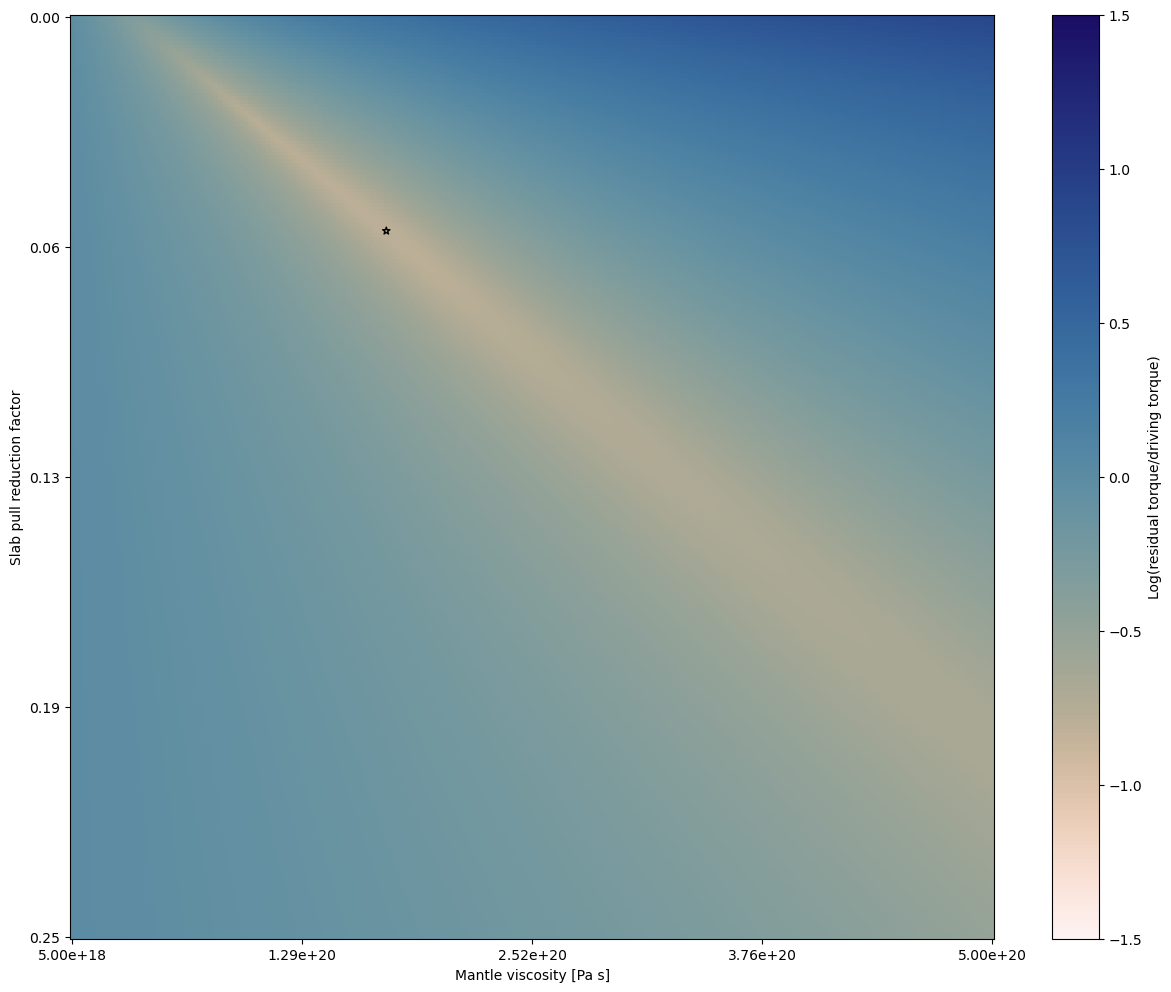

Optimal coefficients for  N America, S America, Pacific, Nazca  plate(s), (PlateIDs:  101.0, 201.0, 901.0, 911.0 )
Minimum residual torque: 15.62% of driving torque
Optimum viscosity [Pa s]: 1.74e+20
Optimum Drag Coefficient [Pa s/m]: 8.70e+14
Optimum Slab Pull constant: 5.82%
Optimum Slab Suction constant: 0.00%
 
Optimising keels
(250, 250, 250)


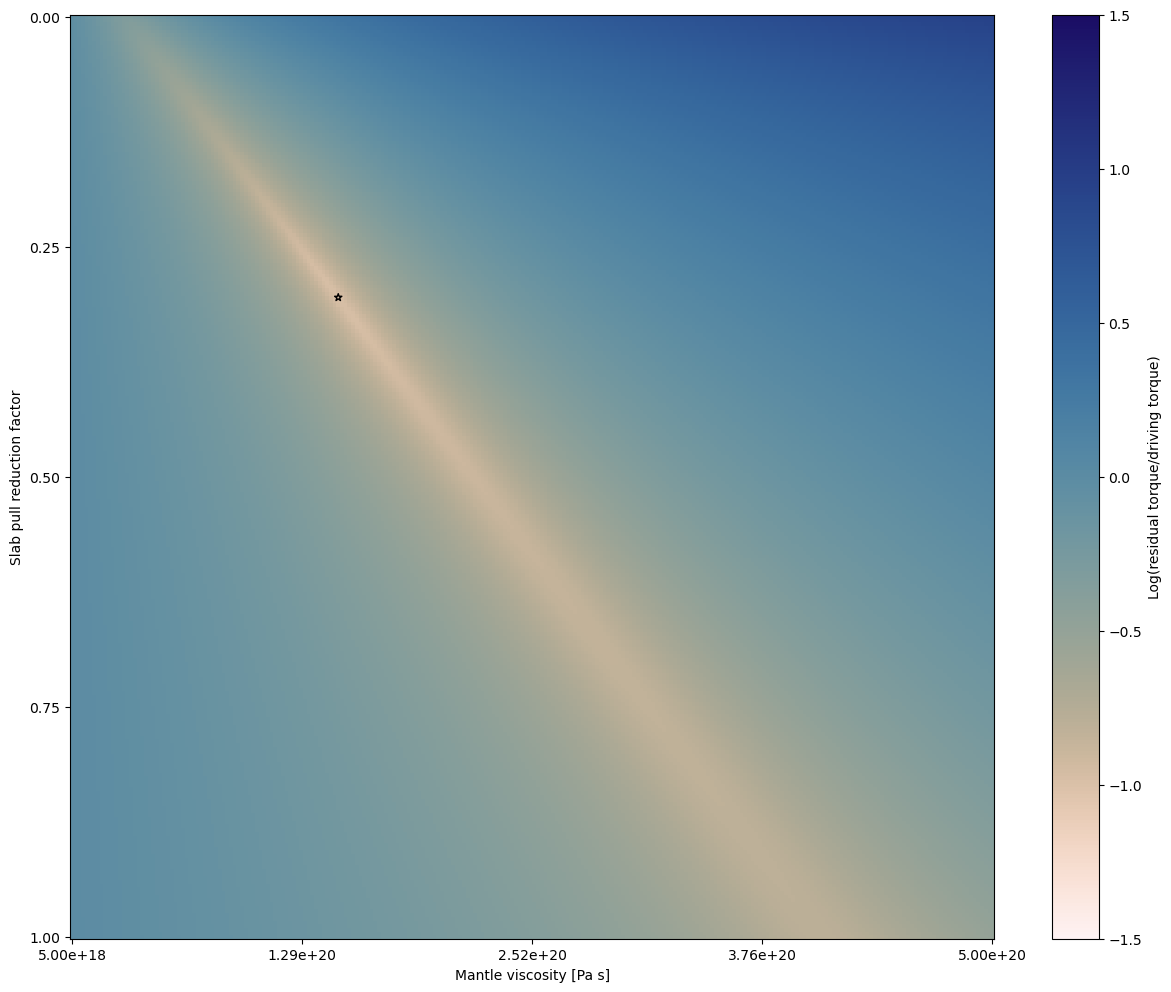

Optimal coefficients for  N America, S America, Pacific, Nazca  plate(s), (PlateIDs:  101.0, 201.0, 901.0, 911.0 )
Minimum residual torque: 10.38% of driving torque
Optimum viscosity [Pa s]: 1.48e+20
Optimum Drag Coefficient [Pa s/m]: 7.41e+14
Optimum Slab Pull constant: 30.52%
Optimum Slab Suction constant: 0.00%
 
Optimising suction
(250, 250, 250)


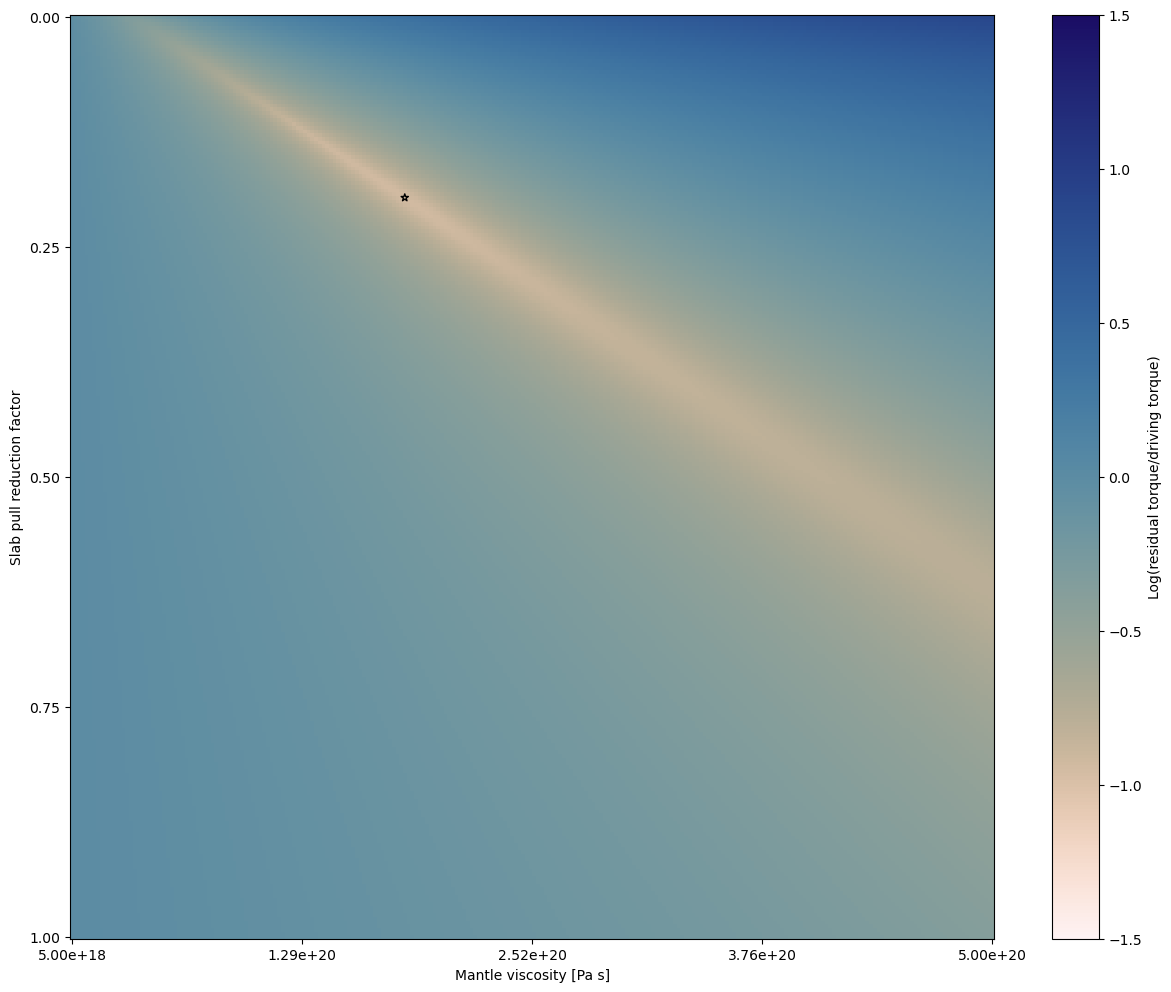

Optimal coefficients for  N America, S America, Pacific, Nazca  plate(s), (PlateIDs:  101.0, 201.0, 901.0, 911.0 )
Minimum residual torque: 11.33% of driving torque
Optimum viscosity [Pa s]: 1.84e+20
Optimum Drag Coefficient [Pa s/m]: 9.20e+14
Optimum Slab Pull constant: 19.68%
Optimum Slab Suction constant: 22.89%
 
Optimising seds_keels
(250, 250, 250)


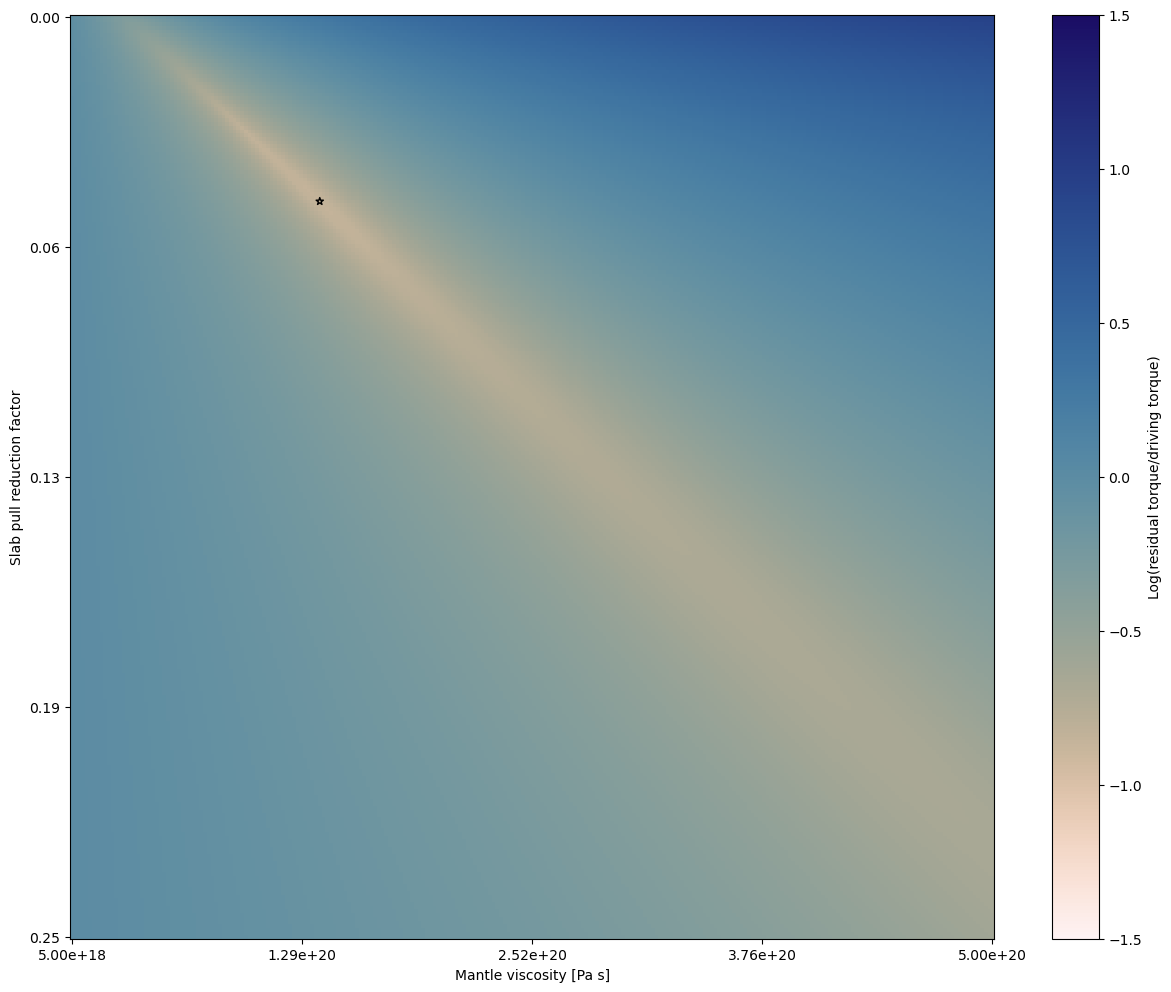

Optimal coefficients for  N America, S America, Pacific, Nazca  plate(s), (PlateIDs:  101.0, 201.0, 901.0, 911.0 )
Minimum residual torque: 13.88% of driving torque
Optimum viscosity [Pa s]: 1.38e+20
Optimum Drag Coefficient [Pa s/m]: 6.91e+14
Optimum Slab Pull constant: 5.02%
Optimum Slab Suction constant: 0.00%
 
Optimising seds_suction
(250, 250, 250)


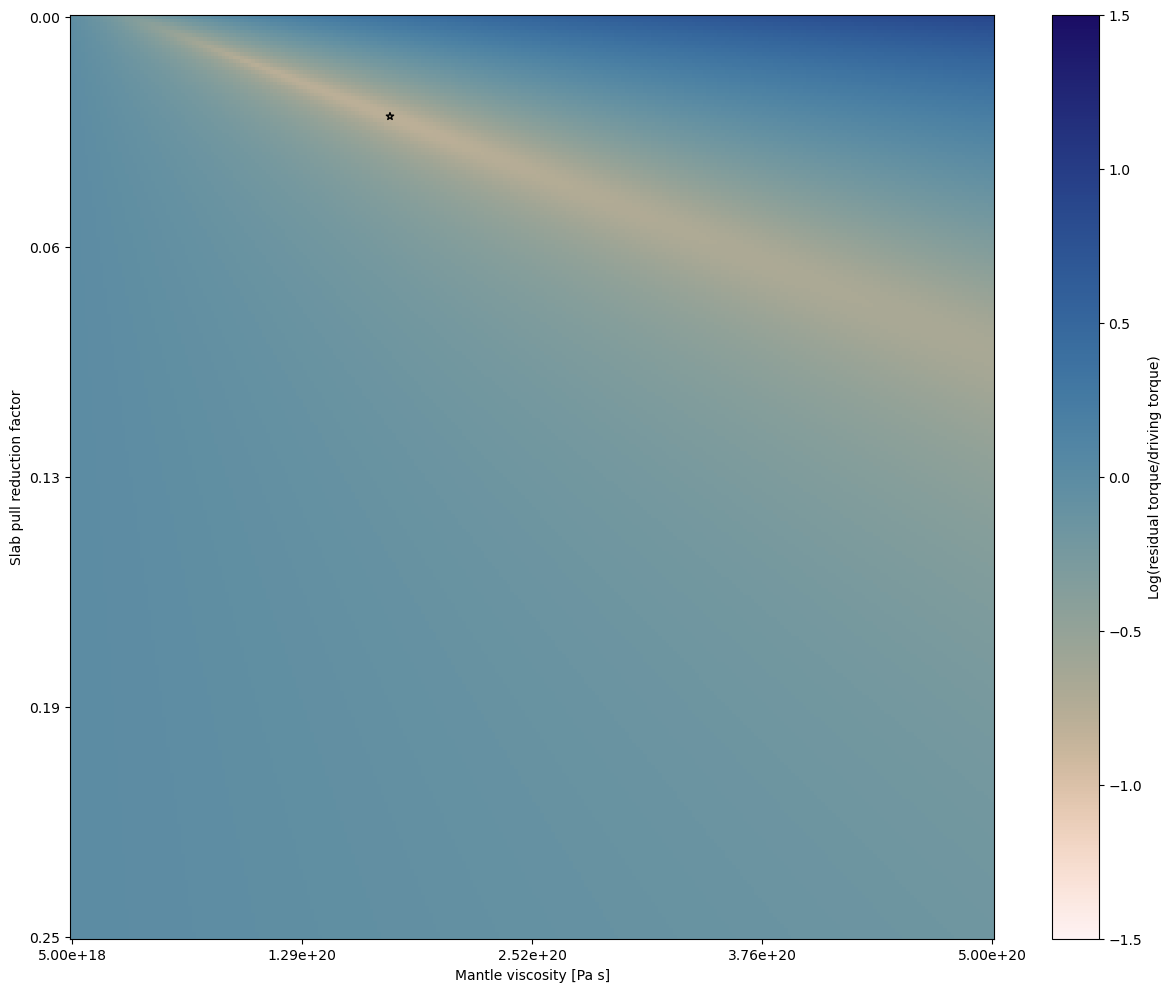

Optimal coefficients for  N America, S America, Pacific, Nazca  plate(s), (PlateIDs:  101.0, 201.0, 901.0, 911.0 )
Minimum residual torque: 15.62% of driving torque
Optimum viscosity [Pa s]: 1.76e+20
Optimum Drag Coefficient [Pa s/m]: 8.80e+14
Optimum Slab Pull constant: 2.71%
Optimum Slab Suction constant: 35.34%
 
Optimising keels_suction
(250, 250, 250)


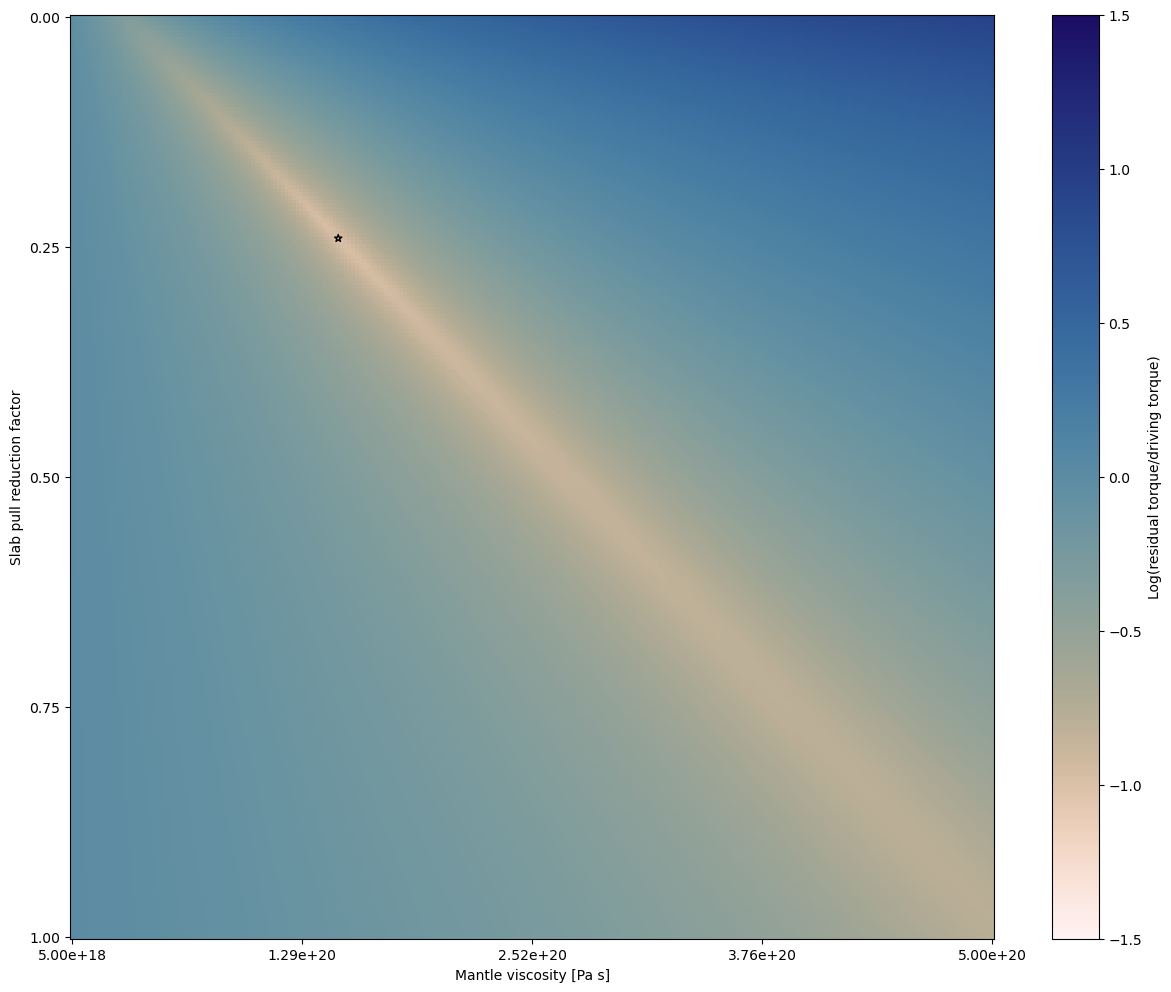

Optimal coefficients for  N America, S America, Pacific, Nazca  plate(s), (PlateIDs:  101.0, 201.0, 901.0, 911.0 )
Minimum residual torque: 10.38% of driving torque
Optimum viscosity [Pa s]: 1.48e+20
Optimum Drag Coefficient [Pa s/m]: 7.41e+14
Optimum Slab Pull constant: 24.10%
Optimum Slab Suction constant: 8.03%
 
Optimising seds_keels_suction
(250, 250, 250)


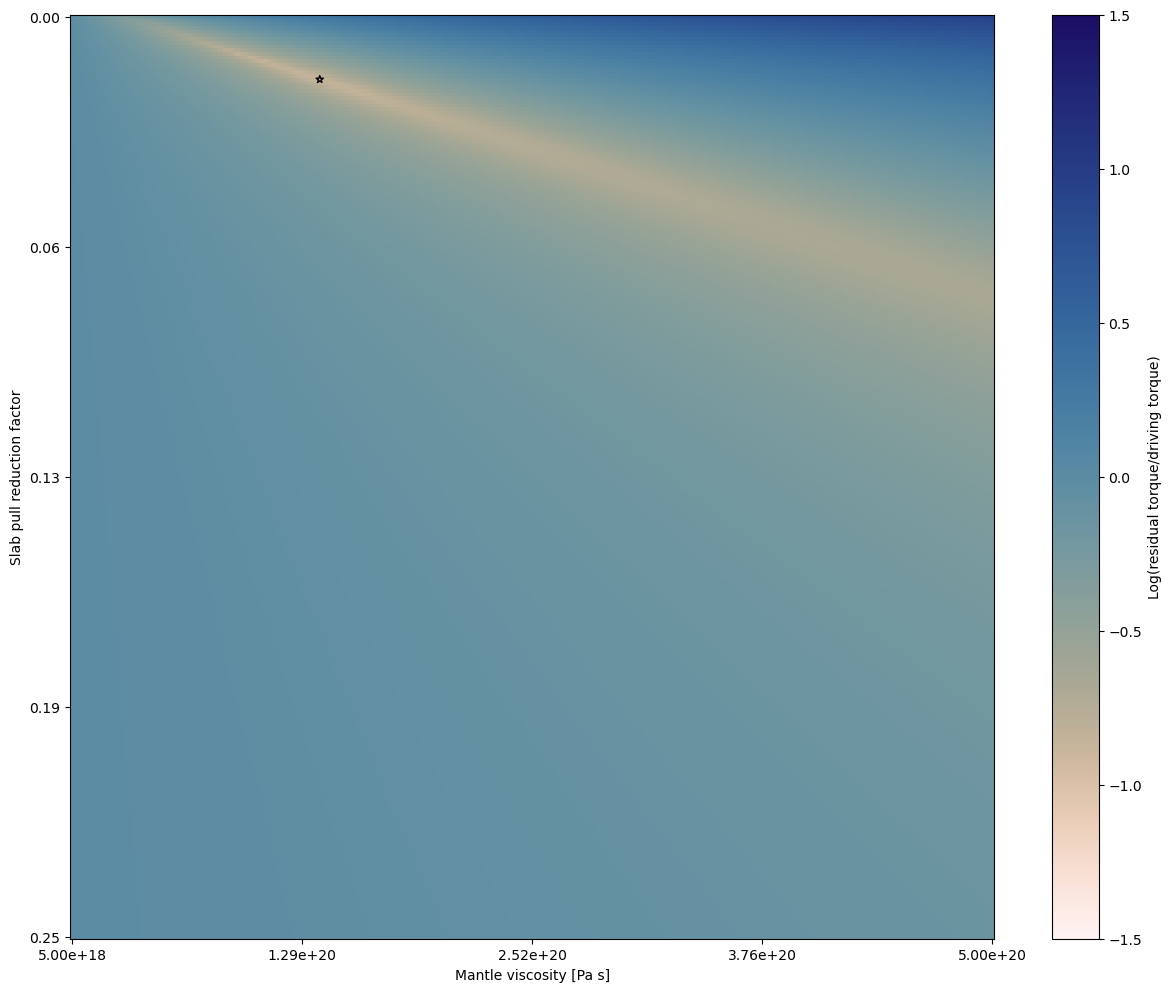

Optimal coefficients for  N America, S America, Pacific, Nazca  plate(s), (PlateIDs:  101.0, 201.0, 901.0, 911.0 )
Minimum residual torque: 13.88% of driving torque
Optimum viscosity [Pa s]: 1.38e+20
Optimum Drag Coefficient [Pa s/m]: 6.91e+14
Optimum Slab Pull constant: 1.71%
Optimum Slab Suction constant: 58.23%


In [12]:
for case in M2016.cases:
    if "syn" in case:
        continue
    
    print(" ")
    print(f"Optimising {case}")
    optimise_M2016.minimise_residual_torque_v4(0, case, plateIDs=[901, 911, 101, 201])

#### __6. Synthetic velocities__

The below cells 

In [ ]:
M2016.calculate_all_torques(cases = "synthetic")